<a href="https://colab.research.google.com/github/smBello-tse/CIFAR10-classification/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from time import time
root = '/kaggle/input'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **I. Data Pre-processing**



In [2]:
#Loading dataset
generator = torch.Generator().manual_seed(42)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

100%|██████████| 170M/170M [00:12<00:00, 13.6MB/s]


Label is: 3
Image shape: torch.Size([3, 32, 32])


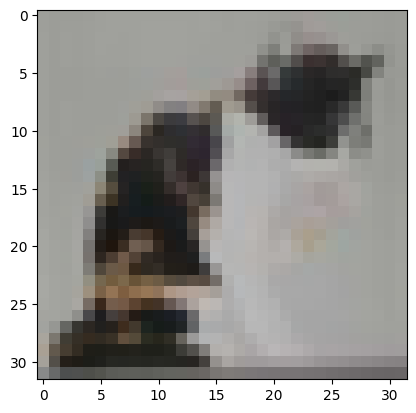

In [3]:
#Visualisation
image, target = train_dataset[785]
print(f"Label is: {target}")
print(f"Image shape: {image.shape}")
image = image.permute(1,2,0).numpy()
plt.imshow(image, cmap="gray")
plt.show()

In [4]:
def compute_mean_std_dataset(dataset):
  imgs = [item[0] for item in train_dataset] # item[0] and item[1] are image and its label
  imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
  mean_r = imgs[:,0,:,:].mean()
  mean_g = imgs[:,1,:,:].mean()
  mean_b = imgs[:,2,:,:].mean()
  means = (mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
  std_r = imgs[:,0,:,:].std()
  std_g = imgs[:,1,:,:].std()
  std_b = imgs[:,2,:,:].std()
  stds = (std_r,std_g,std_b)
  return means, stds

means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_train, stds_train), transforms.RandomRotation(degrees=(-40, 40)), transforms.RandomHorizontalFlip()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_val, stds_val)])
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

In [6]:
#Creating dataloader
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)

# **II. Model implementation**

In [7]:
class Conv_layer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=None, padding=None):
    super().__init__()
    self.stride = 1 if stride is None else stride
    self.padding = 0 if padding is None else padding
    self.conv_layer = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, self.stride, self.padding),
                                          torch.nn.MaxPool2d(kernel_size=2),
                                          torch.nn.LeakyReLU())


  def forward(self, x):
    return self.conv_layer(x)

In [8]:
x, _ = train_dataset[785]
x = x.unsqueeze(0)
conv_layer = Conv_layer(3, 16, 5)
feature_map = conv_layer(x)
print(feature_map.shape)

torch.Size([1, 16, 14, 14])


In [9]:
class My_CNN(torch.nn.Module):

  def __init__(self, in_channels, out_channels, conv_kernels, fc_dims):
    super().__init__()
    self.in_channels = in_channels
    self.conv_kernels = conv_kernels
    self.fc_dims = fc_dims
    self.conv_layers = torch.nn.ModuleList([Conv_layer(cin, cout, kernel) for cin, cout, kernel in zip(in_channels, out_channels, conv_kernels)])
    self.fc_layers = torch.nn.ModuleList([torch.nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(fc_dims[:-1], fc_dims[1:])])
    #self.activation = torch.nn.LeakyReLU(1e-2)

  def forward(self, x):
    for conv_layer in self.conv_layers:
      x = conv_layer(x)
    #print(f"x shape is {x.shape}")
    x = x.view(x.size(0), -1)
    for fc_layer in self.fc_layers[:-1]:
      x = fc_layer(x)
      x = torch.nn.Dropout(0.2)(x)
      x = torch.nn.LeakyReLU(1e-2)(x)
    return self.fc_layers[-1](x)


# **III. Training and test**

In [10]:
def compute_Hf_Wf(conv_kernels, Hi, Wi):
    '''Computes the height and width of the output of the final convolutional layer. This function assumes a maxpool2D of kernel 2x2, as well as default stride(1), padding(0) and dilation(0) for both pooling and convolution.
    Parameters:
        * conv_kernels: a list or tuple of the kernels of the successive convolutional layers
        * Hi: Initial height
        * Wi: Initial width

    Outputs:
        * Hf: final height
        * Wf: final width
    '''

    Hf, Wf = Hi, Wi
    for k in conv_kernels:
      Hf = (Hf - (k - 1)) // 2
      Wf = (Wf - (k - 1)) // 2
    return Hf, Wf


conv_kernels, Hi, Wi = (5,3,3), 32, 32
Hf, Wf = compute_Hf_Wf(conv_kernels, Hi, Wi)
print(Hf, Wf)

2 2


In [11]:
image = train_dataset[785][0]
C, H, W = image.shape
nb_classes = 10
in_channels = (C, 64, 128)
out_channels = (64, 128, 256)
conv_kernels = (5, 3, 3)
Hf, Wf = compute_Hf_Wf(conv_kernels, H, W)
fc_dims = (out_channels[-1]*Hf*Wf, 512, 256, 128, nb_classes)
model = My_CNN(in_channels, out_channels, conv_kernels, fc_dims)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

My_CNN(
  (conv_layers): ModuleList(
    (0): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_

In [12]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")
print(f"Device is {device}")

Number of parameters: 1064202
Device is cuda


In [13]:
if device=="cuda": model = torch.compile(model)

In [14]:
optimizer = None #Just so that I can resume training

In [15]:
#Training and validation
nb_epochs = 150
if optimizer is None: optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
else: print(optimizer)
criterion = torch.nn.CrossEntropyLoss()
losses_train, losses_val = [], []
best_loss = 1e5
lr_decay = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
torch.set_float32_matmul_precision('high')

model.train()

for epoch in range(nb_epochs):
  start = time()
  print(f"Epoch: {epoch}")
  #print("Now training...")
  loss_train, loss_val = 0, 0
  for idx, (batch, target) in tqdm(enumerate(train_loader)):
    batch, target = batch.to(device), target.to(device)
    optimizer.zero_grad()
    #with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    preds = model(batch)
    #print(preds.shape, preds.dtype)
    #print(target.shape, target.dtype)
    loss = criterion(preds, target)
    loss.backward()
    loss_train += loss.item()
    optimizer.step()
  loss_train /= len(train_loader)
  losses_train.append(loss_train)
  scheduler.step()


  #print("Now validation...")
  with torch.no_grad():
    for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = model(batch)
      #print(preds.shape, preds.dtype)
      #print(target.shape, target.dtype)
      loss = criterion(preds, target)
      loss_val += loss.item()
    loss_val /= len(val_loader)
    if loss_val < best_loss:
      best_loss = loss_val
      best_model, best_epoch = model, epoch
    losses_val.append(loss_val)

  print(f"Loss_train: {loss_train:.4f} and loss_val: {loss_val:.4f}")
end = time()


Epoch: 0


391it [00:40,  9.57it/s]
40it [00:01, 35.08it/s]


Loss_train: 1.9581 and loss_val: 1.7077
Epoch: 1


391it [00:40,  9.76it/s]
40it [00:01, 35.90it/s]


Loss_train: 1.6712 and loss_val: 1.5227
Epoch: 2


391it [00:39,  9.83it/s]
40it [00:01, 35.84it/s]


Loss_train: 1.5435 and loss_val: 1.4217
Epoch: 3


391it [00:40,  9.75it/s]
40it [00:01, 35.73it/s]


Loss_train: 1.4613 and loss_val: 1.3936
Epoch: 4


391it [00:39,  9.78it/s]
40it [00:01, 37.00it/s]


Loss_train: 1.4020 and loss_val: 1.2875
Epoch: 5


391it [00:39,  9.80it/s]
40it [00:01, 34.48it/s]


Loss_train: 1.3387 and loss_val: 1.2301
Epoch: 6


391it [00:39,  9.87it/s]
40it [00:01, 34.58it/s]


Loss_train: 1.3008 and loss_val: 1.2078
Epoch: 7


391it [00:39,  9.82it/s]
40it [00:01, 35.88it/s]


Loss_train: 1.2691 and loss_val: 1.2041
Epoch: 8


391it [00:39,  9.88it/s]
40it [00:01, 36.24it/s]


Loss_train: 1.2291 and loss_val: 1.1180
Epoch: 9


391it [00:39,  9.86it/s]
40it [00:01, 36.61it/s]


Loss_train: 1.1960 and loss_val: 1.1017
Epoch: 10


391it [00:39,  9.87it/s]
40it [00:01, 36.12it/s]


Loss_train: 1.1639 and loss_val: 1.0854
Epoch: 11


391it [00:39,  9.83it/s]
40it [00:01, 35.64it/s]


Loss_train: 1.1406 and loss_val: 1.0483
Epoch: 12


391it [00:40,  9.75it/s]
40it [00:01, 35.86it/s]


Loss_train: 1.1188 and loss_val: 1.0233
Epoch: 13


391it [00:40,  9.77it/s]
40it [00:01, 36.06it/s]


Loss_train: 1.0902 and loss_val: 1.0229
Epoch: 14


391it [00:39,  9.93it/s]
40it [00:01, 35.55it/s]


Loss_train: 1.0682 and loss_val: 0.9913
Epoch: 15


391it [00:39,  9.79it/s]
40it [00:01, 35.82it/s]


Loss_train: 1.0494 and loss_val: 0.9894
Epoch: 16


391it [00:40,  9.74it/s]
40it [00:01, 34.79it/s]


Loss_train: 1.0196 and loss_val: 0.9691
Epoch: 17


391it [00:39,  9.79it/s]
40it [00:01, 35.31it/s]


Loss_train: 1.0002 and loss_val: 0.9318
Epoch: 18


391it [00:40,  9.75it/s]
40it [00:01, 34.72it/s]


Loss_train: 0.9813 and loss_val: 0.9399
Epoch: 19


391it [00:40,  9.69it/s]
40it [00:01, 36.17it/s]


Loss_train: 0.9662 and loss_val: 0.9629
Epoch: 20


391it [00:40,  9.76it/s]
40it [00:01, 35.52it/s]


Loss_train: 0.9488 and loss_val: 0.9228
Epoch: 21


391it [00:40,  9.75it/s]
40it [00:01, 35.84it/s]


Loss_train: 0.9297 and loss_val: 0.9084
Epoch: 22


391it [00:39,  9.83it/s]
40it [00:01, 35.95it/s]


Loss_train: 0.9155 and loss_val: 0.8944
Epoch: 23


391it [00:39,  9.84it/s]
40it [00:01, 36.15it/s]


Loss_train: 0.9029 and loss_val: 0.8738
Epoch: 24


391it [00:39,  9.94it/s]
40it [00:01, 36.67it/s]


Loss_train: 0.8872 and loss_val: 0.8849
Epoch: 25


391it [00:39,  9.80it/s]
40it [00:01, 35.21it/s]


Loss_train: 0.8762 and loss_val: 0.8570
Epoch: 26


391it [00:39,  9.84it/s]
40it [00:01, 34.43it/s]


Loss_train: 0.8597 and loss_val: 0.8477
Epoch: 27


391it [00:39,  9.86it/s]
40it [00:01, 35.46it/s]


Loss_train: 0.8464 and loss_val: 0.8457
Epoch: 28


391it [00:39,  9.94it/s]
40it [00:01, 36.60it/s]


Loss_train: 0.8409 and loss_val: 0.8210
Epoch: 29


391it [00:39,  9.90it/s]
40it [00:01, 35.79it/s]


Loss_train: 0.8247 and loss_val: 0.8268
Epoch: 30


391it [00:39,  9.90it/s]
40it [00:01, 36.01it/s]


Loss_train: 0.8215 and loss_val: 0.8142
Epoch: 31


391it [00:39,  9.83it/s]
40it [00:01, 35.93it/s]


Loss_train: 0.8069 and loss_val: 0.8010
Epoch: 32


391it [00:40,  9.68it/s]
40it [00:01, 35.18it/s]


Loss_train: 0.7912 and loss_val: 0.8264
Epoch: 33


391it [00:39,  9.80it/s]
40it [00:01, 35.26it/s]


Loss_train: 0.7820 and loss_val: 0.8077
Epoch: 34


391it [00:40,  9.76it/s]
40it [00:01, 36.52it/s]


Loss_train: 0.7755 and loss_val: 0.7953
Epoch: 35


391it [00:40,  9.72it/s]
40it [00:01, 35.99it/s]


Loss_train: 0.7676 and loss_val: 0.7765
Epoch: 36


391it [00:39,  9.81it/s]
40it [00:01, 36.84it/s]


Loss_train: 0.7561 and loss_val: 0.7759
Epoch: 37


391it [00:38, 10.03it/s]
40it [00:01, 35.60it/s]


Loss_train: 0.7512 and loss_val: 0.7957
Epoch: 38


391it [00:38, 10.21it/s]
40it [00:01, 35.99it/s]


Loss_train: 0.7376 and loss_val: 0.7802
Epoch: 39


391it [00:40,  9.65it/s]
40it [00:01, 34.35it/s]


Loss_train: 0.7287 and loss_val: 0.7672
Epoch: 40


391it [00:40,  9.68it/s]
40it [00:01, 35.93it/s]


Loss_train: 0.7273 and loss_val: 0.7635
Epoch: 41


391it [00:39,  9.91it/s]
40it [00:01, 35.76it/s]


Loss_train: 0.7190 and loss_val: 0.7818
Epoch: 42


391it [00:39,  9.82it/s]
40it [00:01, 36.17it/s]


Loss_train: 0.7099 and loss_val: 0.7518
Epoch: 43


391it [00:39,  9.86it/s]
40it [00:01, 36.70it/s]


Loss_train: 0.7069 and loss_val: 0.7619
Epoch: 44


391it [00:38, 10.15it/s]
40it [00:01, 36.69it/s]


Loss_train: 0.6980 and loss_val: 0.7568
Epoch: 45


391it [00:38, 10.10it/s]
40it [00:01, 36.72it/s]


Loss_train: 0.6921 and loss_val: 0.7535
Epoch: 46


391it [00:38, 10.16it/s]
40it [00:01, 37.17it/s]


Loss_train: 0.6789 and loss_val: 0.7632
Epoch: 47


391it [00:38, 10.22it/s]
40it [00:01, 37.01it/s]


Loss_train: 0.6744 and loss_val: 0.7438
Epoch: 48


391it [00:38, 10.16it/s]
40it [00:01, 35.74it/s]


Loss_train: 0.6694 and loss_val: 0.7475
Epoch: 49


391it [00:38, 10.05it/s]
40it [00:01, 36.39it/s]


Loss_train: 0.6586 and loss_val: 0.7482
Epoch: 50


391it [00:38, 10.09it/s]
40it [00:01, 36.83it/s]


Loss_train: 0.6529 and loss_val: 0.7380
Epoch: 51


391it [00:38, 10.04it/s]
40it [00:01, 34.73it/s]


Loss_train: 0.6512 and loss_val: 0.7426
Epoch: 52


391it [00:38, 10.13it/s]
40it [00:01, 36.55it/s]


Loss_train: 0.6427 and loss_val: 0.7329
Epoch: 53


391it [00:38, 10.15it/s]
40it [00:01, 36.75it/s]


Loss_train: 0.6361 and loss_val: 0.7341
Epoch: 54


391it [00:38, 10.16it/s]
40it [00:01, 37.13it/s]


Loss_train: 0.6326 and loss_val: 0.7367
Epoch: 55


391it [00:38, 10.10it/s]
40it [00:01, 36.82it/s]


Loss_train: 0.6208 and loss_val: 0.7424
Epoch: 56


391it [00:38, 10.13it/s]
40it [00:01, 35.78it/s]


Loss_train: 0.6231 and loss_val: 0.7431
Epoch: 57


391it [00:38, 10.10it/s]
40it [00:01, 35.48it/s]


Loss_train: 0.6118 and loss_val: 0.7432
Epoch: 58


391it [00:38, 10.06it/s]
40it [00:01, 34.36it/s]


Loss_train: 0.6101 and loss_val: 0.7211
Epoch: 59


391it [00:39,  9.98it/s]
40it [00:01, 37.16it/s]


Loss_train: 0.6092 and loss_val: 0.7604
Epoch: 60


391it [00:38, 10.03it/s]
40it [00:01, 35.68it/s]


Loss_train: 0.6000 and loss_val: 0.7287
Epoch: 61


391it [00:38, 10.07it/s]
40it [00:01, 36.32it/s]


Loss_train: 0.5968 and loss_val: 0.7224
Epoch: 62


391it [00:38, 10.07it/s]
40it [00:01, 36.75it/s]


Loss_train: 0.5889 and loss_val: 0.7086
Epoch: 63


391it [00:38, 10.12it/s]
40it [00:01, 35.84it/s]


Loss_train: 0.5859 and loss_val: 0.7075
Epoch: 64


391it [00:38, 10.15it/s]
40it [00:01, 36.14it/s]


Loss_train: 0.5829 and loss_val: 0.7203
Epoch: 65


391it [00:38, 10.16it/s]
40it [00:01, 35.66it/s]


Loss_train: 0.5779 and loss_val: 0.7024
Epoch: 66


391it [00:38, 10.14it/s]
40it [00:01, 33.75it/s]


Loss_train: 0.5683 and loss_val: 0.7160
Epoch: 67


391it [00:38, 10.03it/s]
40it [00:01, 35.90it/s]


Loss_train: 0.5661 and loss_val: 0.7144
Epoch: 68


391it [00:38, 10.06it/s]
40it [00:01, 35.48it/s]


Loss_train: 0.5609 and loss_val: 0.7203
Epoch: 69


391it [00:38, 10.12it/s]
40it [00:01, 36.35it/s]


Loss_train: 0.5573 and loss_val: 0.7196
Epoch: 70


391it [00:38, 10.08it/s]
40it [00:01, 36.48it/s]


Loss_train: 0.5493 and loss_val: 0.7130
Epoch: 71


391it [00:38, 10.13it/s]
40it [00:01, 36.73it/s]


Loss_train: 0.5479 and loss_val: 0.7086
Epoch: 72


391it [00:38, 10.15it/s]
40it [00:01, 36.76it/s]


Loss_train: 0.5426 and loss_val: 0.7215
Epoch: 73


391it [00:38, 10.16it/s]
40it [00:01, 36.53it/s]


Loss_train: 0.5396 and loss_val: 0.7427
Epoch: 74


391it [00:39,  9.92it/s]
40it [00:01, 36.46it/s]


Loss_train: 0.5417 and loss_val: 0.7080
Epoch: 75


391it [00:39,  9.81it/s]
40it [00:01, 34.69it/s]


Loss_train: 0.5339 and loss_val: 0.7290
Epoch: 76


391it [00:40,  9.57it/s]
40it [00:01, 34.78it/s]


Loss_train: 0.5310 and loss_val: 0.6990
Epoch: 77


391it [00:40,  9.64it/s]
40it [00:01, 35.43it/s]


Loss_train: 0.5282 and loss_val: 0.7024
Epoch: 78


391it [00:40,  9.64it/s]
40it [00:01, 34.67it/s]


Loss_train: 0.5195 and loss_val: 0.7036
Epoch: 79


391it [00:40,  9.59it/s]
40it [00:01, 34.52it/s]


Loss_train: 0.5197 and loss_val: 0.7080
Epoch: 80


391it [00:40,  9.72it/s]
40it [00:01, 36.22it/s]


Loss_train: 0.5139 and loss_val: 0.7072
Epoch: 81


391it [00:40,  9.54it/s]
40it [00:01, 33.08it/s]


Loss_train: 0.5090 and loss_val: 0.7094
Epoch: 82


391it [00:40,  9.63it/s]
40it [00:01, 33.93it/s]


Loss_train: 0.5127 and loss_val: 0.7178
Epoch: 83


391it [00:41,  9.50it/s]
40it [00:01, 34.85it/s]


Loss_train: 0.5055 and loss_val: 0.7143
Epoch: 84


391it [00:41,  9.49it/s]
40it [00:01, 35.65it/s]


Loss_train: 0.5010 and loss_val: 0.7229
Epoch: 85


391it [00:40,  9.69it/s]
40it [00:01, 36.00it/s]


Loss_train: 0.4955 and loss_val: 0.7005
Epoch: 86


391it [00:40,  9.74it/s]
40it [00:01, 35.31it/s]


Loss_train: 0.4916 and loss_val: 0.7071
Epoch: 87


391it [00:40,  9.75it/s]
40it [00:01, 35.92it/s]


Loss_train: 0.4892 and loss_val: 0.7008
Epoch: 88


391it [00:40,  9.75it/s]
40it [00:01, 35.60it/s]


Loss_train: 0.4876 and loss_val: 0.7261
Epoch: 89


391it [00:40,  9.61it/s]
40it [00:01, 35.39it/s]


Loss_train: 0.4859 and loss_val: 0.7099
Epoch: 90


391it [00:40,  9.68it/s]
40it [00:01, 35.89it/s]


Loss_train: 0.4855 and loss_val: 0.7021
Epoch: 91


391it [00:40,  9.72it/s]
40it [00:01, 35.40it/s]


Loss_train: 0.4772 and loss_val: 0.7133
Epoch: 92


391it [00:40,  9.77it/s]
40it [00:01, 36.01it/s]


Loss_train: 0.4773 and loss_val: 0.7057
Epoch: 93


391it [00:40,  9.63it/s]
40it [00:01, 34.02it/s]


Loss_train: 0.4725 and loss_val: 0.7138
Epoch: 94


391it [00:40,  9.60it/s]
40it [00:01, 34.64it/s]


Loss_train: 0.4721 and loss_val: 0.7244
Epoch: 95


391it [00:40,  9.65it/s]
40it [00:01, 36.16it/s]


Loss_train: 0.4679 and loss_val: 0.7235
Epoch: 96


391it [00:40,  9.67it/s]
40it [00:01, 35.66it/s]


Loss_train: 0.4636 and loss_val: 0.7182
Epoch: 97


391it [00:40,  9.58it/s]
40it [00:01, 34.79it/s]


Loss_train: 0.4655 and loss_val: 0.7158
Epoch: 98


391it [00:40,  9.54it/s]
40it [00:01, 31.82it/s]


Loss_train: 0.4580 and loss_val: 0.7320
Epoch: 99


391it [00:43,  8.95it/s]
40it [00:01, 34.45it/s]


Loss_train: 0.4561 and loss_val: 0.6967
Epoch: 100


391it [00:40,  9.62it/s]
40it [00:01, 35.60it/s]


Loss_train: 0.4535 and loss_val: 0.7113
Epoch: 101


391it [00:39,  9.80it/s]
40it [00:01, 35.61it/s]


Loss_train: 0.4493 and loss_val: 0.7127
Epoch: 102


391it [00:39,  9.80it/s]
40it [00:01, 36.27it/s]


Loss_train: 0.4471 and loss_val: 0.7535
Epoch: 103


391it [00:39,  9.79it/s]
40it [00:01, 36.54it/s]


Loss_train: 0.4460 and loss_val: 0.7054
Epoch: 104


391it [00:39,  9.90it/s]
40it [00:01, 36.52it/s]


Loss_train: 0.4419 and loss_val: 0.7372
Epoch: 105


391it [00:39,  9.94it/s]
40it [00:01, 35.09it/s]


Loss_train: 0.4421 and loss_val: 0.7050
Epoch: 106


391it [00:39,  9.97it/s]
40it [00:01, 35.15it/s]


Loss_train: 0.4353 and loss_val: 0.7237
Epoch: 107


391it [00:39,  9.86it/s]
40it [00:01, 35.77it/s]


Loss_train: 0.4365 and loss_val: 0.7226
Epoch: 108


391it [00:39,  9.78it/s]
40it [00:01, 32.71it/s]


Loss_train: 0.4335 and loss_val: 0.7268
Epoch: 109


391it [00:39,  9.87it/s]
40it [00:01, 36.34it/s]


Loss_train: 0.4292 and loss_val: 0.7141
Epoch: 110


391it [00:39,  9.82it/s]
40it [00:01, 34.40it/s]


Loss_train: 0.4296 and loss_val: 0.7102
Epoch: 111


391it [00:39,  9.87it/s]
40it [00:01, 36.03it/s]


Loss_train: 0.4261 and loss_val: 0.7246
Epoch: 112


391it [00:39,  9.83it/s]
40it [00:01, 35.82it/s]


Loss_train: 0.4192 and loss_val: 0.7363
Epoch: 113


391it [00:40,  9.73it/s]
40it [00:01, 35.33it/s]


Loss_train: 0.4226 and loss_val: 0.7128
Epoch: 114


391it [00:38, 10.06it/s]
40it [00:01, 37.44it/s]


Loss_train: 0.4188 and loss_val: 0.7400
Epoch: 115


391it [00:38, 10.06it/s]
40it [00:01, 37.20it/s]


Loss_train: 0.4171 and loss_val: 0.7062
Epoch: 116


391it [00:38, 10.22it/s]
40it [00:01, 32.65it/s]


Loss_train: 0.4126 and loss_val: 0.7328
Epoch: 117


391it [00:38, 10.16it/s]
40it [00:01, 36.68it/s]


Loss_train: 0.4149 and loss_val: 0.7309
Epoch: 118


391it [00:39,  9.93it/s]
40it [00:01, 37.09it/s]


Loss_train: 0.4047 and loss_val: 0.7083
Epoch: 119


391it [00:39,  9.82it/s]
40it [00:01, 36.12it/s]


Loss_train: 0.4073 and loss_val: 0.7163
Epoch: 120


391it [00:39,  9.85it/s]
40it [00:01, 33.40it/s]


Loss_train: 0.4029 and loss_val: 0.7225
Epoch: 121


391it [00:40,  9.77it/s]
40it [00:01, 36.00it/s]


Loss_train: 0.4022 and loss_val: 0.7371
Epoch: 122


391it [00:40,  9.72it/s]
40it [00:01, 35.97it/s]


Loss_train: 0.4028 and loss_val: 0.7466
Epoch: 123


391it [00:39,  9.82it/s]
40it [00:01, 35.28it/s]


Loss_train: 0.3982 and loss_val: 0.7328
Epoch: 124


391it [00:40,  9.65it/s]
40it [00:01, 35.35it/s]


Loss_train: 0.3995 and loss_val: 0.7216
Epoch: 125


391it [00:40,  9.69it/s]
40it [00:01, 36.36it/s]


Loss_train: 0.3964 and loss_val: 0.7400
Epoch: 126


391it [00:40,  9.65it/s]
40it [00:01, 35.52it/s]


Loss_train: 0.3936 and loss_val: 0.7346
Epoch: 127


391it [00:40,  9.63it/s]
40it [00:01, 35.39it/s]


Loss_train: 0.3900 and loss_val: 0.7327
Epoch: 128


391it [00:40,  9.72it/s]
40it [00:01, 36.19it/s]


Loss_train: 0.3897 and loss_val: 0.7336
Epoch: 129


391it [00:39,  9.91it/s]
40it [00:01, 35.46it/s]


Loss_train: 0.3861 and loss_val: 0.7279
Epoch: 130


391it [00:39,  9.83it/s]
40it [00:01, 35.29it/s]


Loss_train: 0.3858 and loss_val: 0.7324
Epoch: 131


391it [00:39,  9.85it/s]
40it [00:01, 36.39it/s]


Loss_train: 0.3874 and loss_val: 0.7248
Epoch: 132


391it [00:40,  9.71it/s]
40it [00:01, 35.76it/s]


Loss_train: 0.3836 and loss_val: 0.7187
Epoch: 133


391it [00:39,  9.85it/s]
40it [00:01, 36.13it/s]


Loss_train: 0.3826 and loss_val: 0.7304
Epoch: 134


391it [00:39,  9.81it/s]
40it [00:01, 33.99it/s]


Loss_train: 0.3777 and loss_val: 0.7311
Epoch: 135


391it [00:39,  9.83it/s]
40it [00:01, 36.71it/s]


Loss_train: 0.3772 and loss_val: 0.7296
Epoch: 136


391it [00:39,  9.85it/s]
40it [00:01, 36.76it/s]


Loss_train: 0.3777 and loss_val: 0.7226
Epoch: 137


391it [00:39,  9.92it/s]
40it [00:01, 36.29it/s]


Loss_train: 0.3773 and loss_val: 0.7513
Epoch: 138


391it [00:39,  9.84it/s]
40it [00:01, 36.48it/s]


Loss_train: 0.3749 and loss_val: 0.7308
Epoch: 139


391it [00:39,  9.88it/s]
40it [00:01, 36.85it/s]


Loss_train: 0.3680 and loss_val: 0.7509
Epoch: 140


391it [00:39,  9.88it/s]
40it [00:01, 36.28it/s]


Loss_train: 0.3750 and loss_val: 0.7402
Epoch: 141


391it [00:39,  9.95it/s]
40it [00:01, 34.52it/s]


Loss_train: 0.3703 and loss_val: 0.7273
Epoch: 142


391it [00:39,  9.80it/s]
40it [00:01, 36.28it/s]


Loss_train: 0.3680 and loss_val: 0.7393
Epoch: 143


391it [00:40,  9.66it/s]
40it [00:01, 35.93it/s]


Loss_train: 0.3625 and loss_val: 0.7445
Epoch: 144


391it [00:40,  9.70it/s]
40it [00:01, 35.42it/s]


Loss_train: 0.3627 and loss_val: 0.7419
Epoch: 145


391it [00:40,  9.70it/s]
40it [00:01, 34.91it/s]


Loss_train: 0.3635 and loss_val: 0.7649
Epoch: 146


391it [00:40,  9.69it/s]
40it [00:01, 35.19it/s]


Loss_train: 0.3596 and loss_val: 0.7501
Epoch: 147


391it [00:40,  9.62it/s]
40it [00:01, 35.28it/s]


Loss_train: 0.3627 and loss_val: 0.7332
Epoch: 148


391it [00:40,  9.57it/s]
40it [00:01, 35.03it/s]


Loss_train: 0.3577 and loss_val: 0.7512
Epoch: 149


391it [00:40,  9.62it/s]
40it [00:01, 34.73it/s]

Loss_train: 0.3556 and loss_val: 0.7446


Time elapsed: 41.82078504562378
Seconds per epoch: 0.2788052336374919
Best epoch: 99
Best loss: 0.6967


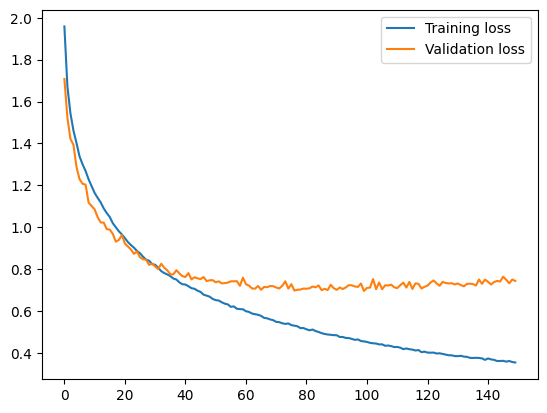

In [16]:
time_elapsed = end- start
print(f"Time elapsed: {time_elapsed}")
print(f"Seconds per epoch: {time_elapsed / nb_epochs}")
print(f"Best epoch: {best_epoch}")
print(f"Best loss: {best_loss:.4f}")

epochs = range(nb_epochs)

plt.plot(epochs, losses_train, label="Training loss")
plt.plot(epochs, losses_val, label="Validation loss")
plt.legend()
plt.show()

In [17]:
#Test on val data
best_model.eval()
print("Now testing...")
loss_test = 0
test_batch = next(iter(val_loader))
all_preds = []
all_targets = []
with torch.no_grad():
  for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = best_model(batch)
      loss = criterion(preds, target)
      loss_test += loss.item()
      all_preds.append(torch.argmax(preds, dim=-1).cpu().numpy())
      all_targets.append(target.cpu().numpy())
  all_preds = np.concatenate(all_preds)
  all_targets = np.concatenate(all_targets)
  loss_test /= len(val_loader)

  print(f"Loss_test: {loss_test:.4f}")

Now testing...


40it [00:01, 34.74it/s]

Loss_test: 0.7535


<Axes: >

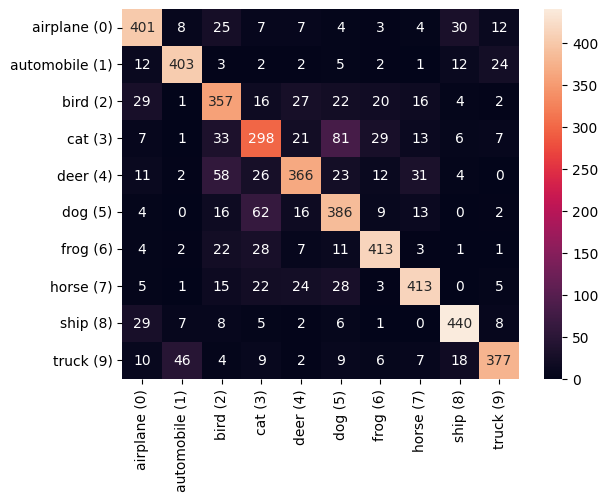

In [18]:
labels = ["airplane (0)", "automobile (1)", "bird (2)", "cat (3)", "deer (4)", "dog (5)", "frog (6)", "horse (7)", "ship (8)", "truck (9)"]
#
cm = confusion_matrix(all_targets, all_preds, labels=range(10))
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(cm_df, annot=True, fmt="d")

In [19]:
print(f"Accuracy score is: {accuracy_score(all_targets, all_preds)}")

Accuracy score is: 0.7708


In [20]:
def accuracy_multi_class(y_true, y_pred, cm):
  '''
  y_true: true labels
  y_pred: predicted labels
  cm: confusion matrix

  return list of accuracies for each classes
  '''
  accuracies = np.zeros((cm.shape[0],))
  for i in range(cm.shape[0]):
    accuracies[i] = cm[i,i] / np.sum(cm[i,:])
  return accuracies

accuracies = accuracy_multi_class(all_targets, all_preds, cm)
accuracies_df = pd.DataFrame(accuracies, index=labels, columns=["Accuracy"])
accuracies_df = accuracies_df.sort_values(by="Accuracy", ascending=False)
print(accuracies_df)
print("Mean of accuracies: ", accuracies_df["Accuracy"].mean())

                Accuracy
ship (8)        0.869565
automobile (1)  0.864807
frog (6)        0.839431
airplane (0)    0.800399
horse (7)       0.800388
truck (9)       0.772541
dog (5)         0.759843
bird (2)        0.722672
deer (4)        0.686679
cat (3)         0.600806
Mean of accuracies:  0.7717130971314949


In [21]:
checkpoint = {
    "model": best_model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "best_loss": best_loss,
    "epoch": best_epoch
}

# Save to a file in the working directory
torch.save(checkpoint, "/kaggle/working/checkpoint_LeakyReLU_dropout.pth")